In [78]:
#!pip install dlib

## Install

[taken from here](https://www.learnopencv.com/install-dlib-on-ubuntu/) [*www.learnopencv.com/install-dlib-on-ubuntu*]

In [79]:
#!apt-get install build-essential cmake pkg-config

In [80]:
#!apt-get install libx11-dev libatlas-base-dev

In [81]:
#!apt-get install libgtk-3-dev libboost-python-dev -y

## Compile DLIB

In [82]:
#%cd /root

In [83]:
#!wget http://dlib.net/files/dlib-19.4.tar.bz2

In [84]:
#!tar xvf dlib-19.4.tar.bz2

In [85]:
#%cd dlib-19.4/

In [86]:
#!mkdir build

In [87]:
#%cd build

In [88]:
#!cmake ..

In [89]:
#!cmake --build . --config Release

In [90]:
#!make install

In [91]:
#!ldconfig

In [92]:
#%cd ..

In [93]:
#!pkg-config --libs --cflags dlib-1

In [94]:
#!pip install dlib

In [95]:
#%cd /root/jupyterdata

## Facial Landmarks

See blog post here - https://matthewearl.github.io/2015/07/28/switching-eds-with-python/


#### Install Instructions for dlib

- Download and Install Dlib

https://sourceforge.net/projects/dclib/

- Extract files in C:/dlib 
- Use command prompt to Cd to folder and run “python setup.py install”

#### Download the pre-trained model here 

http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

- Place this file in your default ipython notebook folder


In [4]:
import notebook_util
import cv2
from matplotlib import pyplot as plt
import numpy as np
import dlib
notebook_util.override_imshow(cv2)

%matplotlib inline

In [5]:
PREDICTOR_PATH = "./resources/shape_predictor_68_face_landmarks.dat"

In [6]:
predictor = dlib.shape_predictor(PREDICTOR_PATH)
detector = dlib.get_frontal_face_detector()

In [8]:
class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

def get_landmarks(im):
    rects = detector(im, 1)

    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces

    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im

Showing Image: Original


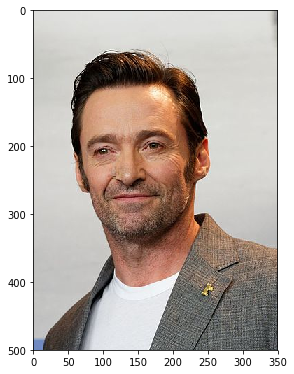

In [34]:
image = cv2.imread('./resources/Patrick_Stewart_and_Hugh_Jackman_Press_Conference_Logan_Berlinale_2017_01.jpg')
image = image[:500,450:800]
cv2.imshow("Original", image)

In [35]:
landmarks = get_landmarks(image)

In [36]:
image_with_landmarks = annotate_landmarks(image, landmarks)

Showing Image: Result


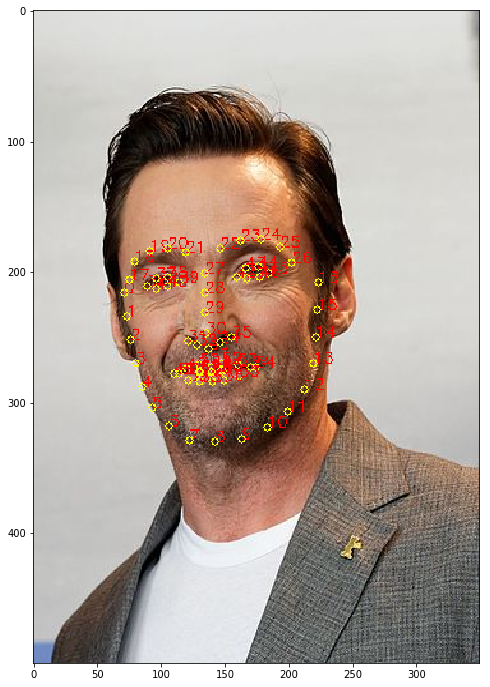

In [37]:
cv2.imshow('Result', image_with_landmarks, (8,12))

Showing Image: Original


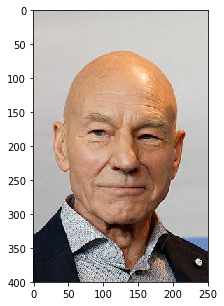

In [31]:
image = cv2.imread('./resources/Patrick_Stewart_and_Hugh_Jackman_Press_Conference_Logan_Berlinale_2017_01.jpg')
image = image[150:550,200:450]
cv2.imshow("Original", image)

Showing Image: Result


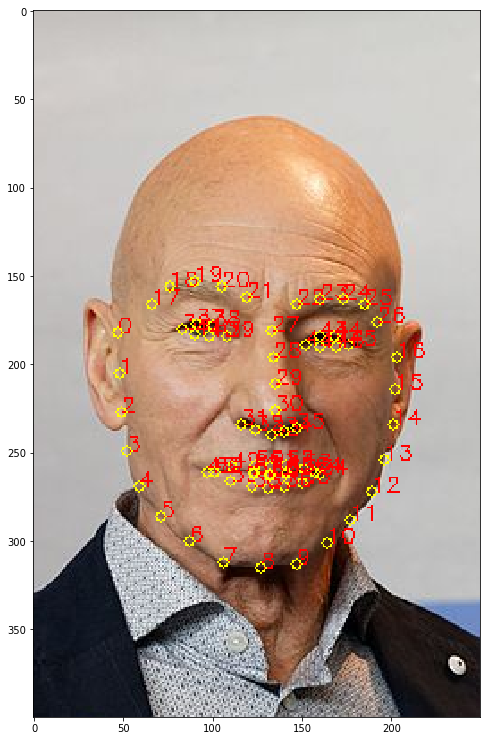

In [32]:
landmarks = get_landmarks(image)
image_with_landmarks = annotate_landmarks(image, landmarks)
cv2.imshow('Result', image_with_landmarks, (8,13))

Showing Image: Original


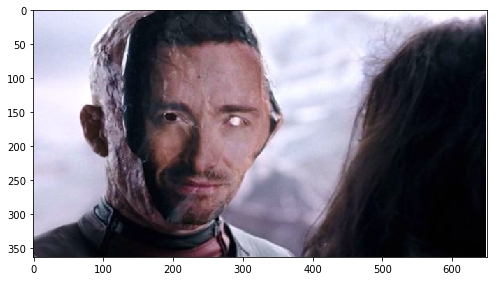

Showing Image: Result


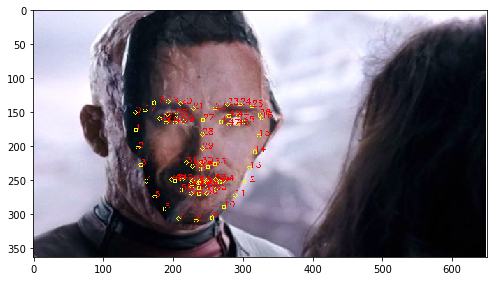

In [40]:
image = cv2.imread('./resources/ryan-reynolds-hugh-jackman-deadpool.jpg')
image = image[:,:]
cv2.imshow("Original", image)
landmarks = get_landmarks(image)
image_with_landmarks = annotate_landmarks(image, landmarks)
cv2.imshow('Result', image_with_landmarks)

Showing Image: Original


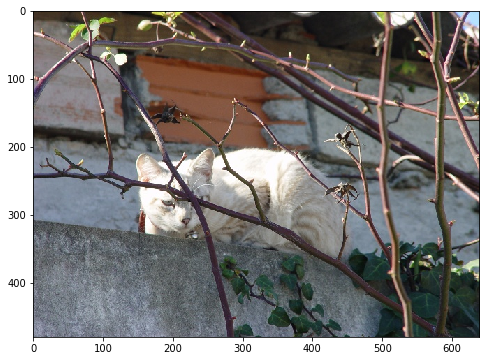

NoFaces: 

In [41]:
image = cv2.imread('./resources/cat.jpg')
image = image[:,:]
cv2.imshow("Original", image)
landmarks = get_landmarks(image)
image_with_landmarks = annotate_landmarks(image, landmarks)
cv2.imshow('Result', image_with_landmarks)

Showing Image: Original


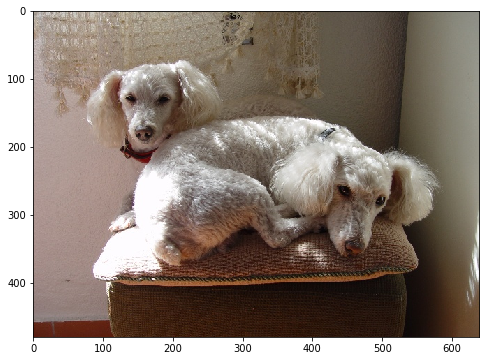

Showing Image: Result


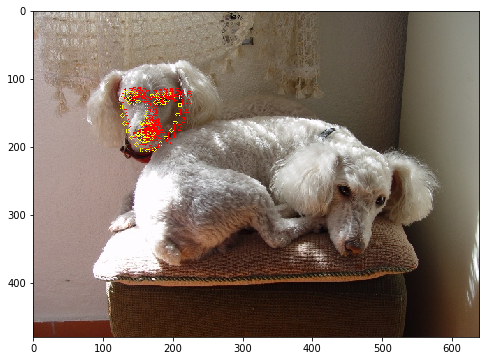

In [46]:
image = cv2.imread('./resources/dogs3.jpg')
image = image[:,:]
cv2.imshow("Original", image)
landmarks = get_landmarks(image)
image_with_landmarks = annotate_landmarks(image, landmarks)
cv2.imshow('Result', image_with_landmarks)

## Merge Face

In [52]:
PREDICTOR_PATH = "./resources/shape_predictor_68_face_landmarks.dat"
SCALE_FACTOR = 1 
FEATHER_AMOUNT = 11

FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

# Points used to line up the images.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

# Points from the second image to overlay on the first. The convex hull of each
# element will be overlaid.
OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]

# Amount of blur to use during colour correction, as a fraction of the
# pupillary distance.
COLOUR_CORRECT_BLUR_FRAC = 0.6

In [50]:
def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

def get_face_mask(im, landmarks):
    im = np.zeros(im.shape[:2], dtype=np.float64)

    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                         landmarks[group],
                         color=1)

    im = np.array([im, im, im]).transpose((1, 2, 0))

    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)

    return im
    
def transformation_from_points(points1, points2):
    """
    Return an affine transformation [s * R | T] such that:
        sum ||s*R*p1,i + T - p2,i||^2
    is minimized.
    """
    # Solve the procrustes problem by subtracting centroids, scaling by the
    # standard deviation, and then using the SVD to calculate the rotation. See
    # the following for more details:
    #   https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem

    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)

    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = np.linalg.svd(points1.T * points2)

    # The R we seek is in fact the transpose of the one given by U * Vt. This
    # is because the above formulation assumes the matrix goes on the right
    # (with row vectors) where as our solution requires the matrix to be on the
    # left (with column vectors).
    R = (U * Vt).T

    return np.vstack([np.hstack(((s2 / s1) * R,
                                       c2.T - (s2 / s1) * R * c1.T)),
                         np.matrix([0., 0., 1.])])

def read_im_and_landmarks(image):
    im = image
    im = cv2.resize(im,None,fx=1, fy=1, interpolation = cv2.INTER_LINEAR)
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR,
                         im.shape[0] * SCALE_FACTOR))
    s = get_landmarks(im)

    return im, s

def warp_im(im, M, dshape):
    output_im = np.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im

def correct_colours(im1, im2, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
                              np.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              np.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    # Avoid divide-by-zero errors.
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    return (im2.astype(np.float64) * im1_blur.astype(np.float64) /
                                                im2_blur.astype(np.float64))


def swappy(image1, image2):
       
    im1, landmarks1 = read_im_and_landmarks(image1)
    im2, landmarks2 = read_im_and_landmarks(image2)

    M = transformation_from_points(landmarks1[ALIGN_POINTS],
                                   landmarks2[ALIGN_POINTS])
    
    mask = get_face_mask(im2, landmarks2)
    warped_mask = warp_im(mask, M, im1.shape)
    combined_mask = np.max([get_face_mask(im1, landmarks1), warped_mask],
                              axis=0)

    warped_im2 = warp_im(im2, M, im1.shape)
    warped_corrected_im2 = correct_colours(im1, warped_im2, landmarks1)

    output_im = im1 * (1.0 - combined_mask) + warped_corrected_im2 * combined_mask
    cv2.imwrite('output.jpg', output_im)
    image = cv2.imread('output.jpg')
    return image

In [67]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

In [68]:
## Enter the paths to your input images here
logan_im = cv2.imread('resources/Patrick_Stewart_and_Hugh_Jackman_Press_Conference_Logan_Berlinale_2017_01.jpg')

image1 = logan_im[150:550,200:450]
image2 = logan_im[:500,450:800]

Showing Image: Face Swap 1


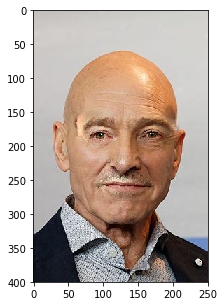

Showing Image: Face Swap 2


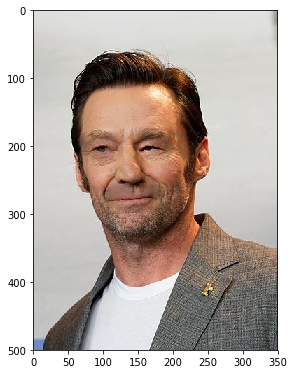

In [69]:
swapped = swappy(image1, image2)
cv2.imshow('Face Swap 1', swapped)
swapped = swappy(image2, image1)
cv2.imshow('Face Swap 2', swapped)

In [70]:
dogs_im = cv2.imread('resources/dogs3.jpg')
image3 = dogs_im[50:250,50:300]

Showing Image: Face Swap 1


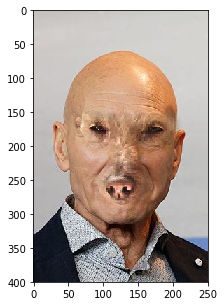

Showing Image: Face Swap 2


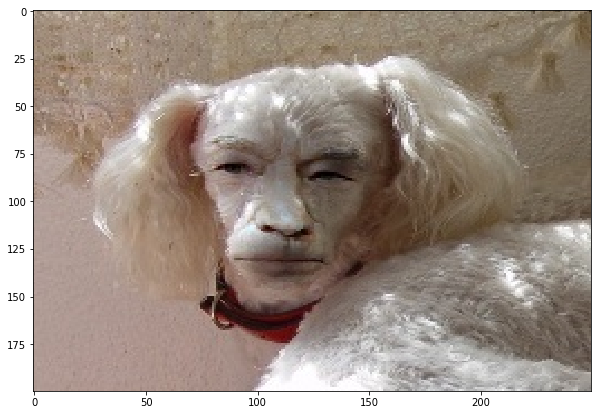

In [77]:
swapped = swappy(image1, image3)
cv2.imshow('Face Swap 1', swapped)
swapped = swappy(image3, image1)
cv2.imshow('Face Swap 2', swapped, (10,7))

Showing Image: Face Swap 1


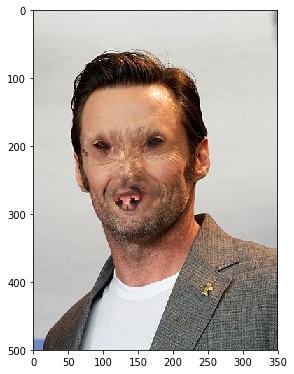

Showing Image: Face Swap 2


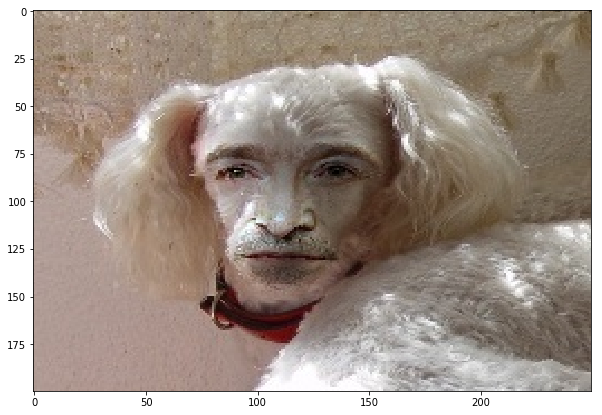

In [76]:
swapped = swappy(image2, image3)
cv2.imshow('Face Swap 1', swapped)
swapped = swappy(image3, image2)
cv2.imshow('Face Swap 2', swapped, (10,7))